In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import re

import numpy as np
import matplotlib.pyplot as plt

import cx_spiking.plotting
from cx_spiking.constants import *

In [29]:
regex_params = r'Candidate\(args=\((\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+)'
regex_params_2 = r'Candidate\(args=\((\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+)'
regex_fitness = r'Updating fitness with value (\d+(\.\d*)?|\.\d+)'
regex_mean = r'mean: (\d+(\.\d*)?|\.\d+)'
regex_gamma = r'Gamma factor: (\d+(\.\d*)?|\.\d+)'
regex_gamma_double = r'Gamma factor: (\d+(\.\d*)?|\.\d+) - (\d+(\.\d*)?|\.\d+)'

In [166]:
def parse_file(path, regex_params, regex_fitness, regex_mean, regex_gamma, group=[1,3,5,7]):
    params = []
    fitness = []
    mean = []
    gamma = []
    
    f = os.path.join(os.environ.get('MSC_PROJECT'), path)
    with open(f, 'r') as fh:
        lines = fh.readlines() 

    for line in lines:
        matches_params = re.search(regex_params, line)
        matches_fitness = re.search(regex_fitness, line)
        matches_mean = re.search(regex_mean, line)
        matches_gamma = re.search(regex_gamma, line)
        
        if matches_params:
            p = []
            for g in group:
                x = float(matches_params.group(g))
                p.append(x)
            params.append(p)
        if matches_fitness:
            fitness.append(float(matches_fitness.group(1)))
        if matches_mean:
            mean.append(float(matches_mean.group(1)))
        if matches_gamma:
            gamma.append(float(matches_gamma.group(1)))
            #if matches_gamma.group(3):
            #    gamma.append(float(matches_gamma.group(3)))


    params = np.array(params)
    fitness = np.array(fitness)
    mean = np.array(mean)
    gamma = np.array(gamma)
    
    return params, fitness, mean, gamma

def plot_mean(means, names, ylim=[1,2], savefig_=None):
    for mean, name in zip(means, names):
        plt.plot(mean, label=name)
    plt.title('mean')
    plt.ylim(ylim)
    plt.ylabel('mean')
    plt.xlabel('#iter')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()


def plot_gamma(gammas, names, ylim=[1,5], alpha=0.9, 
               title='',figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for gamma, name in zip(gammas, names):
        plt.plot(gamma, label=name, alpha=alpha)

    plt.ylim(ylim)
    plt.title(title)
    plt.ylabel('Gamma factor')
    plt.xlabel('Iterations')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
def plot_tauE(params, names, params_idx=0, ylim=[0.1,5], alpha=0.9, 
              title='', figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for param, name in zip(params, names):
        if len(param):
            plt.plot(param[:,params_idx], label=name, alpha=alpha)
    plt.ylim(ylim)
    plt.ylabel(r'$\tau_E$')
    plt.xlabel('Iterations')
    plt.title(title)
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
def plot_wE(params, names, params_idx=1, ylim=[200,1000], alpha=0.9, 
            title='', figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for param, name in zip(params, names):
        if len(param):
            plt.plot(param[:,params_idx], label=name, alpha=alpha)
    plt.ylim(ylim)
    plt.ylabel(r'$w_E$')
    plt.xlabel('Iterations')
    plt.title(title)
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
    
def plot_three(gammas, wes, taues, names, title, titles,
               fontsize=14, 
               alpha=0.8, figsize=(13,10), savefig_=None):
    fig, ax = plt.subplots(3, figsize=figsize, sharex=True, gridspec_kw={'hspace': 0.1})
    
    ax[0].set_title(title, fontsize=fontsize)
    
    for gamma, name in zip(gammas, names):
        ax[0].plot(gamma, label=name, alpha=alpha)
    y_ticks=['1','3','5']
    ax[0].set_yticks([1,3,5])
    ax[0].set_yticklabels(y_ticks,fontsize=fontsize-2)

    ax[0].set_ylim([1,5])
    ax[0].set_ylabel('Gamma factor', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize)

    for we, name in zip(wes, names):
        if len(we):
            ax[1].plot(we[:,1], label=name, alpha=alpha)
    y_ticks=['200','600','1000']
    ax[1].set_yticks([200,600,1000])
    ax[1].set_yticklabels(y_ticks, rotation=0, fontsize=fontsize-2)

    ax[1].set_ylabel(r'$w_E$ [nS]', fontsize=fontsize)
    #ax[1].legend(fontsize=fontsize)

    for taue, name in zip(taues, names):
        ax[2].plot(taue[:,0], label=name, alpha=alpha)
    y_ticks=['1','3','5']
    ax[2].set_yticks([1,3,5])
    ax[2].set_yticklabels(y_ticks, rotation=0, fontsize=fontsize-2)
    ax[2].set_ylabel(r'$\tau_E$ [ms]', fontsize=fontsize)
    ax[2].set_xlabel('Iterations', fontsize=fontsize)
    #ax[2].legend(fontsize=fontsize)

    for a in ax:
        a.label_outer()

    if savefig_:
        fig.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/{savefig_}.pdf'),
            bbox_inches='tight')
    fig.show()


def print_mean_std(params, names):
    for param, name in zip(params, names):
        print(name)
        print(f'tauE mean {param[:,0].mean():.4f} - std {param[:,0].std():.4f}')
        print(f'wE mean {param[:,1].mean():.4f} - std {param[:,1].std():.4f}')
        print()
        
def plot_gamma_factors(gamma_factors, tauE_s, wE_s, figsize=(13,5), savefig_=None):
    c = np.argwhere(gamma_factors == np.min(gamma_factors))[0]
    
    plt.figure(figsize=(11,7))
    plt.pcolormesh(gamma_factors,cmap='viridis', rasterized=True)
    plt.plot(c[1]+0.5, c[0]+0.5, 'rx')
    plt.xlabel('wE (nS)')
    plt.ylabel('tauE (ms)')
    plt.yticks(np.arange(len(tauE_s))+0.5, tauE_s)
    plt.xticks(np.arange(len(wE_s))+0.5, wE_s)
    plt.colorbar()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()

# TL2

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]



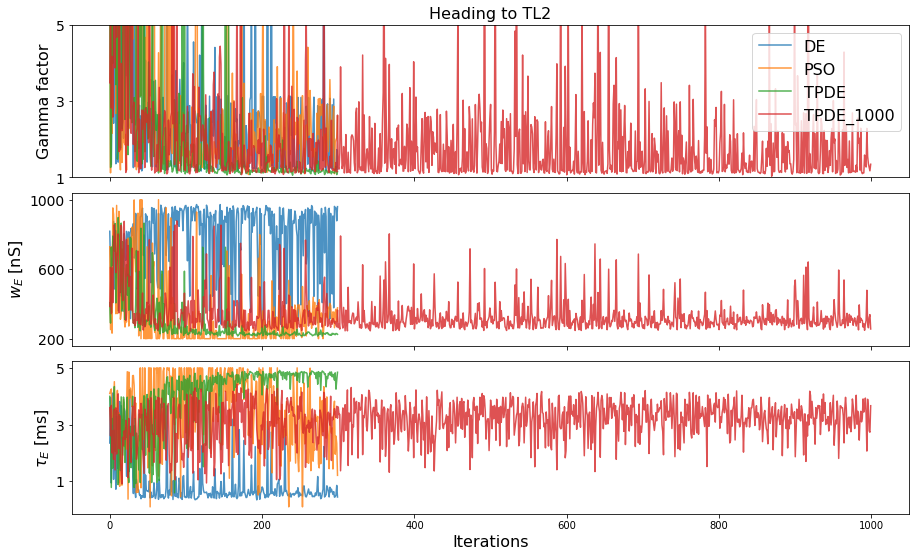

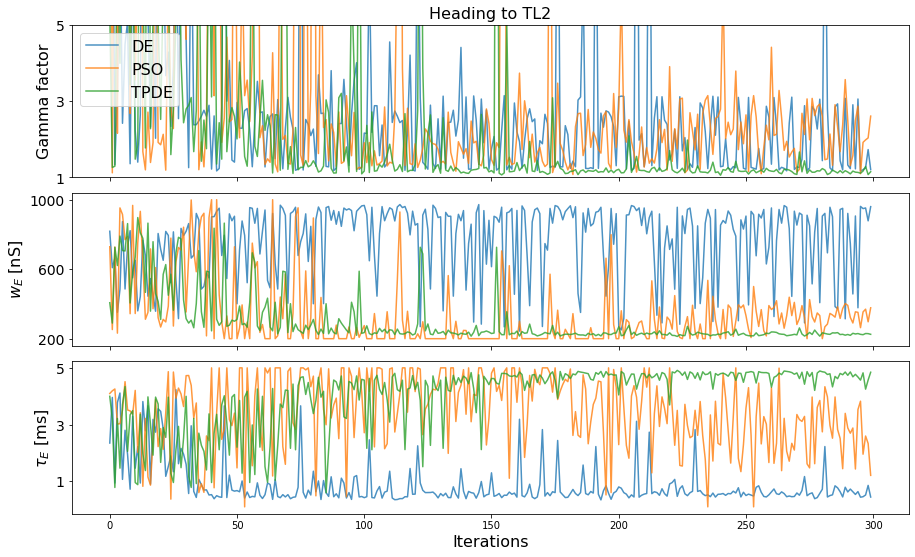

In [206]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/TL2/outputs/TL2_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/TL2/outputs/TL2_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/TL2/outputs/TL2_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/TL2/outputs/TL2_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/TL2/outputs/TL2_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)
GS_p, GS_f, GS_m, GS_g = parse_file('optimisation_scripts/TL2/outputs/TL2_grid_search.out', regex_params_2, regex_fitness, regex_mean, regex_gamma, group=[1,3])

names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000', 'GS']
TL2_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m, GS_m]
TL2_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g, GS_g]
TL2_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f, GS_f]
TL2_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p, GS_p]
# plot_mean(TL2_means, names)
# plot_gamma(TL2_gammas, names,  alpha=0.6)
# plot_gamma([DE_g, PSO_g, TPDE_g], ['DE', 'PSO', 'TPDE'], alpha=0.8,
#           title='Gamma Factor - Heading to TL2', figsize=(15,3))
# plot_gamma([GS_g], ['GS'], alpha=0.6)
#plot_tauE([DE_p, PSO_p, TPDE_p], ['DE', 'PSO', 'TPDE'], alpha=0.8, 
#         title=r'$\tau_E$ - Heading to TL2', figsize=(15,3))
#plot_wE([DE_p, PSO_p, TPDE_p], ['DE', 'PSO', 'TPDE'], alpha=0.8,
#        title=r'$w_E$ - Heading to TL2', figsize=(15,3))
# print_mean_std(TL2_params, names)


titles = ['Gamma Factor - Heading to TL2', r'$w_E$ - Heading to TL2', r'$\tau_E$ - Heading to TL2']

plot_three([DE_g, PSO_g, TPDE_g, TPDE_1000_g], [DE_p, PSO_p, TPDE_p, TPDE_1000_p], 
           [DE_p, PSO_p, TPDE_p, TPDE_1000_p], ['DE', 'PSO', 'TPDE', 'TPDE_1000'],
           fontsize=16,
           title='Heading to TL2', titles=titles, alpha=0.8, figsize=(15,9), savefig_='heading_tl2_ev_tpde1000')

plot_three([DE_g, PSO_g, TPDE_g], [DE_p, PSO_p, TPDE_p], 
           [DE_p, PSO_p, TPDE_p], ['DE', 'PSO', 'TPDE'],
           fontsize=16,
           title='Heading to TL2', titles=titles, alpha=0.8, figsize=(15,9), savefig_='heading_tl2_ev')

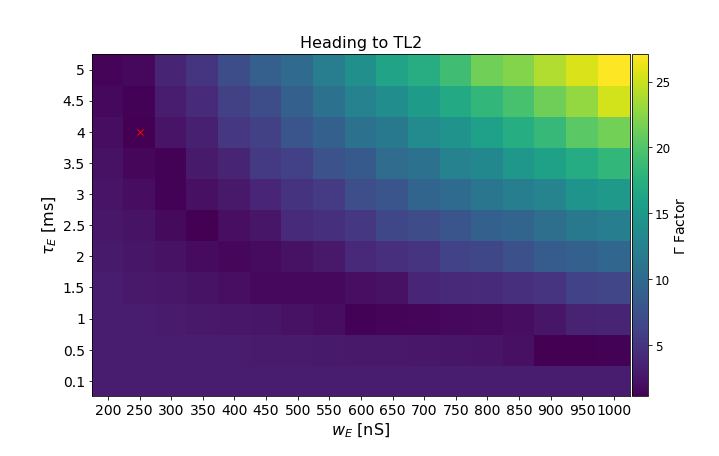

In [196]:
TL2_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TL2/outputs/TL2_gamma_factors_grid_search.csv', delimiter=',')

cx_spiking.plotting.plot_gamma_factors(TL2_grid_search, tauE_s, wE_s, title='Heading to TL2',
                                       figsize=(11,7), 
                                       savefig_=os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/gs_heading_tl2.pdf'))

# TN2

In [207]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/TN2/outputs/TN2_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/TN2/outputs/TN2_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/TN2/outputs/TN2_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/TN2/outputs/TN2_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/TN2/outputs/TN2_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)
GS_p, GS_f, GS_m, GS_g = parse_file('optimisation_scripts/TN2/outputs/TN2_grid_search.out', regex_params_2, regex_fitness, regex_mean, regex_gamma, group=[1,3])

names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000', 'GS']
TN2_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m, GS_m]
TN2_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g, GS_g]
TN2_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f, GS_f]
TN2_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p, GS_p]

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]



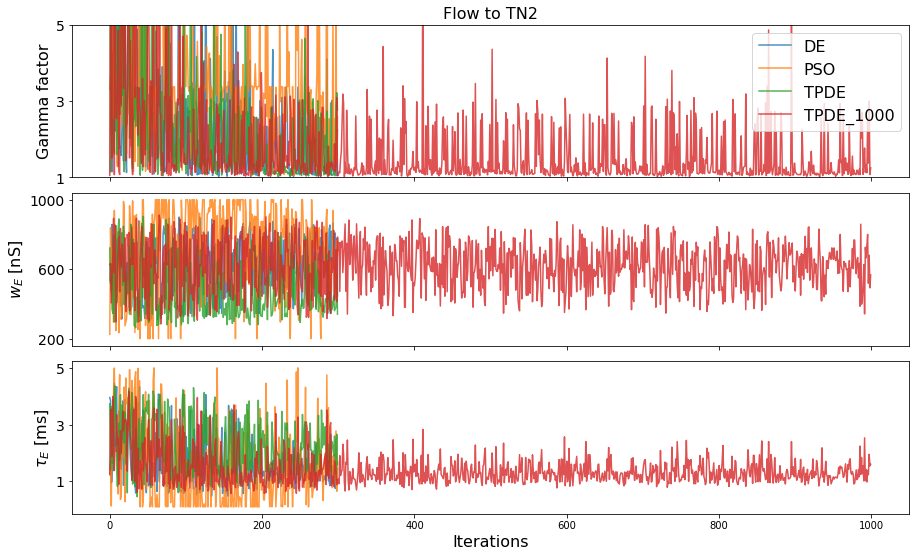

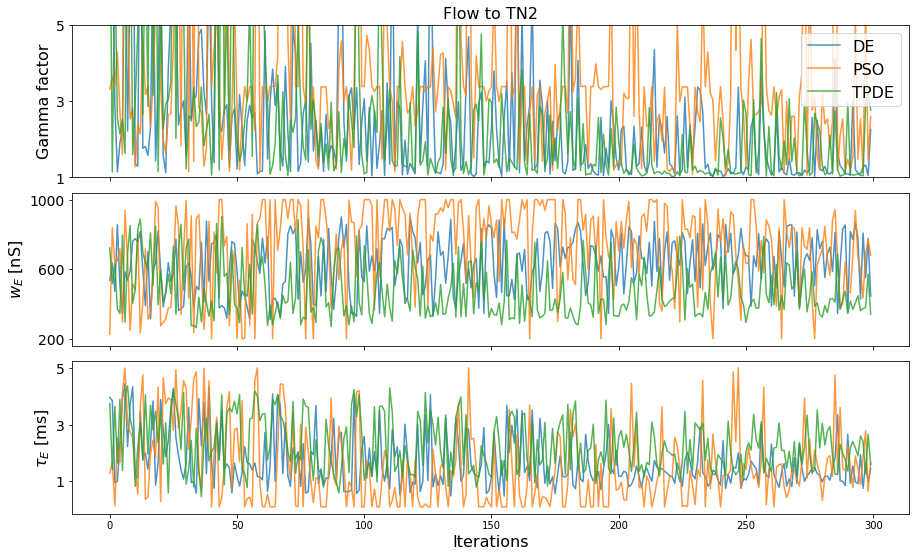

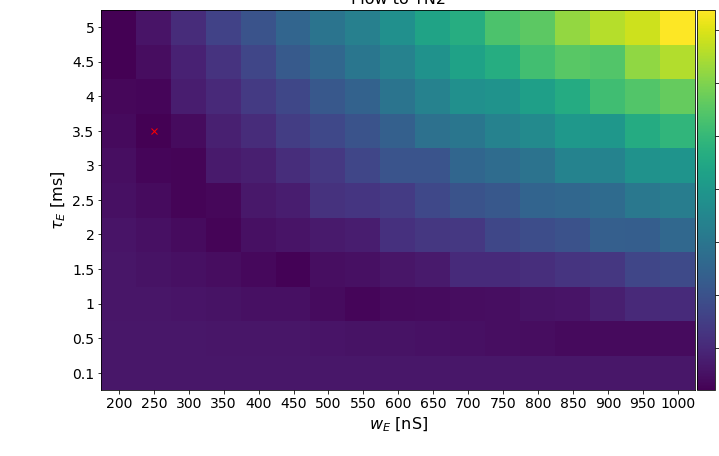

In [208]:
# plot_mean(TN2_means, names, ylim=[1,10])
# plot_gamma(TN2_gammas, names, ylim=[1,5], alpha=0.6)
# plot_gamma([TPDE_g, TPDE_1000_g, GD_g], ['TPDE', 'TPDE_1000', 'GD'], alpha=0.6)
# plot_gamma([GD_g], ['GD'], alpha=0.6)
# plot_tauE(TN2_params, names, alpha=0.6)
# plot_wE(TN2_params, names, alpha=0.6)
# print_mean_std(TN2_params, names)

titles = ['Gamma Factor - Heading to TL2', r'$w_E$ - Heading to TL2', r'$\tau_E$ - Heading to TL2']

plot_three([DE_g, PSO_g, TPDE_g, TPDE_1000_g], [DE_p, PSO_p, TPDE_p, TPDE_1000_p], 
           [DE_p, PSO_p, TPDE_p, TPDE_1000_p], ['DE', 'PSO', 'TPDE', 'TPDE_1000'],            
           fontsize=16,
           title='Flow to TN2', titles=titles, alpha=0.8, figsize=(15,9), savefig_='flow_tn2_ev_tpde1000')

plot_three([DE_g, PSO_g, TPDE_g], [DE_p, PSO_p, TPDE_p], 
           [DE_p, PSO_p, TPDE_p], ['DE', 'PSO', 'TPDE'],            
           fontsize=16,
           title='Flow to TN2', titles=titles, alpha=0.8, figsize=(15,9), savefig_='flow_tn2_ev')

TN2_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TN2/outputs/TN2_gamma_factors_grid_search.csv', delimiter=',')

cx_spiking.plotting.plot_gamma_factors(TN2_grid_search, tauE_s, wE_s, title='Flow to TN2',
                                       figsize=(11,7), 
                                       savefig_=os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/gs_flow_tn2.pdf'))

# CL1

In [ ]:
In the ``TL2 - CL1'' optimisation task both excitatory and inhibitory synaptic weights \(w_E,\ w_I\) and excitatory and inhibitory time constants \(\tau_E,\ \tau_I\) need to be found.

Due to the 


In [202]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/CL1/outputs/CL1_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/CL1/outputs/CL1_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)
GS_p, GS_f, GS_m, GS_g = parse_file('optimisation_scripts/CL1/outputs/CL1_grid_search.out', regex_params_2, regex_fitness, regex_mean, regex_gamma, group=[1,3])

names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000', 'GS']
CL1_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m, GS_m]
CL1_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g, GS_g]
CL1_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f, GS_f]
CL1_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p, GS_p]

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]

WARNING    /Users/ff/.pyenv/versions/3.7.8/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]



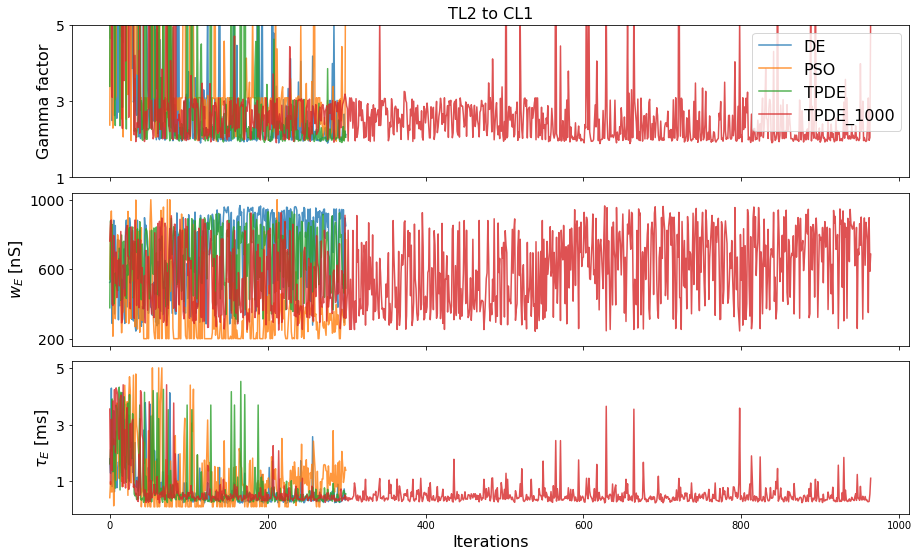

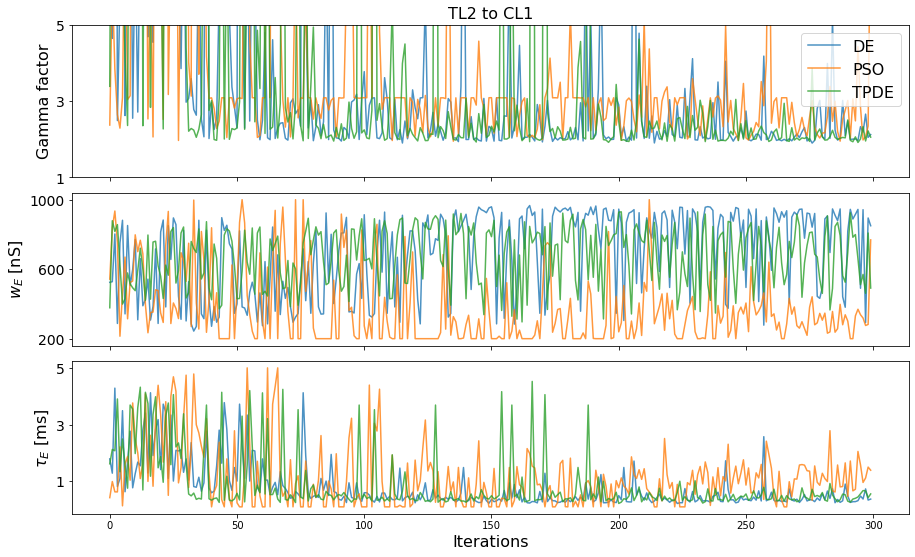

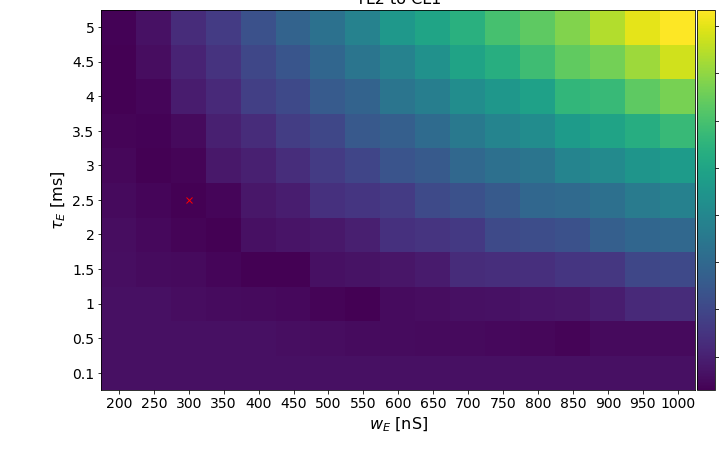

In [205]:
titles = ['Gamma Factor - Heading to TL2', r'$w_E$ - Heading to TL2', r'$\tau_E$ - Heading to TL2']

plot_three([DE_g, PSO_g, TPDE_g, TPDE_1000_g], [DE_p, PSO_p, TPDE_p, TPDE_1000_p], 
           [DE_p, PSO_p, TPDE_p, TPDE_1000_p], ['DE', 'PSO', 'TPDE', 'TPDE_1000'],            
           fontsize=16,
           title='TL2 to CL1', titles=titles, alpha=0.8, figsize=(15,9), savefig_='tl2_cl1_ev_tpde1000')

plot_three([DE_g, PSO_g, TPDE_g], [DE_p, PSO_p, TPDE_p], 
           [DE_p, PSO_p, TPDE_p], ['DE', 'PSO', 'TPDE'],            
           fontsize=16,
           title='TL2 to CL1', titles=titles, alpha=0.8, figsize=(15,9), savefig_='tl2_cl1_ev')

CL1_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/CL1/outputs/CL1_gamma_factors_grid_search.csv', delimiter=',')

cx_spiking.plotting.plot_gamma_factors(CL1_grid_search, tauE_s, wE_s, title='TL2 to CL1',
                                       figsize=(11,7), 
                                       savefig_=os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/gs_tl2_cl1.pdf'))

# Grid Search results

In [200]:
TL2_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TL2/outputs/TL2_gamma_factors_grid_search.csv', delimiter=',')
TN2_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TN2/outputs_new/TN2_gamma_factors_grid_search.csv', delimiter=',')
CL1_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/CL1/outputs/CL1_gamma_factors_grid_search.csv', delimiter=',')
#TB1_grid_search = np.genfromtxt('/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TB1/outputs/TB1_gamma_factors_grid_search.csv', delimiter=',')

In [201]:
def get_min_grid_search(matrix, tauE_s, wE_s, limit=10):
    flatten_m = matrix.flatten()
    sorted_c = np.argsort(flatten_m)
    for i in range(len(flatten_m[:limit])):
        c = np.unravel_index(sorted_c[i], matrix.shape)
        print(flatten_m[sorted_c[i]], tauE_s[c[0]], wE_s[c[1]])

print('TL2')
get_min_grid_search(TL2_grid_search, tauE_s, wE_s, limit=10)



print()
print('TN2')
get_min_grid_search(TN2_grid_search, tauE_s, wE_s, limit=10)

print()
print('CL1')
get_min_grid_search(CL1_grid_search, tauE_s, wE_s, limit=10)

#print()
#print('TB1')
#get_min_grid_search(TB1_grid_search, tauI_s, wI_s, limit=10)

TL2
1.1272131778354364 4 250
1.1285188538391713 2.5 350
1.219115102961368 0.5 900
1.2275216440840953 0.5 950
1.2577586089763368 3 300
1.2605724211178901 0.5 1000
1.2942752463712552 3.5 300
1.3114101397983107 4.5 250
1.3220847341530577 1 600
1.3911850187442072 1 650

TN2
1.0764185288089112 3.5 250
1.1121477165431037 5 200
1.1824515511618023 4.5 200
1.2346343498438177 1.5 450
1.419410345904713 3 300
1.4339781998569983 2 350
1.4684085571626588 2.5 300
1.5530077041419283 3 250
1.587825127984625 4 250
1.6119036708132914 1 550

CL1
1.4386831981676407 2.5 300
1.4758043864195307 2 350
1.4770102205778535 1.5 450
1.478756279162368 4.5 200
1.5060375305648896 3 250
1.5449889186917893 1 550
1.5613095022943106 4 200
1.5763523961304573 1.5 400
1.6025044227871563 3.5 250
1.7342630350419017 5 200


# TB1

In [59]:
tauE_s_full = [0.1, 0.5, 1, 1.5, 2] # ms
wE_s_full = [550, 600, 650, 700, 750] # nS
tauI_s_full = [0.1, 0.5, 1, 1.5, 2] # ms
wI_s_full = [550, 600, 650, 700, 750] # nS


tauE_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wE_s_full = [300, 400, 500, 600, 700, 800] # nS
tauI_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wI_s_full = [400, 500, 600, 700, 800, 900] # nS
gamma_factors = np.zeros((len(tauE_s_full), len(wE_s_full), len(tauI_s_full), len(wI_s_full)))


# load 5 TB1 npz
for t in range(len(tauE_s_full)):
    with open(f'/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/TB1/outputs/TB1_gamma_factors_grid_search_{t}.npz', 'rb') as f:
        data = np.load(f)
        gamma_factors[t,:,:,:] = data[t,:,:,:]


In [60]:
def get_min_grid_search_full(matrix, tauE_s, wE_s, tauI_s, wI_s, limit=10):
    flatten_m = matrix.flatten()
    #print(flatten_m)
    sorted_c = np.argsort(flatten_m)
    for i in range(len(flatten_m[:10])):
        c = np.unravel_index(sorted_c[i], gamma_factors.shape)
        print(flatten_m[sorted_c[i]], tauE_s[c[0]], wE_s[c[1]], tauI_s[c[2]], wI_s[c[3]])
    #return 

get_min_grid_search_full(gamma_factors, tauE_s_full, wE_s_full, tauI_s_full, wI_s_full, limit=10)

1.2756183210063794 0.5 800 1 700
1.2850767922616848 1.5 300 0.5 800
1.2875676963971916 0.5 800 2 400
1.3192215388405992 1.5 300 1.5 400
1.3196857410682394 0.5 800 1.5 600
1.3251761798148167 1.5 300 0.5 900
1.335487089214834 0.5 800 1 600
1.3357854299458594 1.5 300 1.5 700
1.3395243223737279 1.5 300 1 500
1.3473301052271074 0.5 800 1.5 900


# CPU4

In [52]:
tauE_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wE_s_full = [300, 400, 500, 600, 700, 800] # nS
tauI_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wI_s_full = [400, 500, 600, 700, 800, 900] # nS

In [72]:

for t in range(len(tauE_s_full)):
    _, _, _, CPU4_g = parse_file(f'optimisation_scripts/NETWORK_FULL/outputs/NET_grid_search_{t}.out', 
                               regex_params, regex_fitness, regex_mean, regex_gamma_double)
    reshaped = CPU4_g.reshape(-1,2)
    print(reshaped.min())
    #flatten_m = reshaped[:,1].flatten()
    #sorted_c = np.argsort(flatten_m)
    #for i in range(len(flatten_m[:10])):
    #    c = np.unravel_index(sorted_c[i], gamma_factors.shape)
        

1.1551896791255007
1.2635366887436672
1.21977499897278
1.3069264621524845
1.3676361979605824


In [53]:
gamma_factors = np.zeros((len(tauE_s_full), len(wE_s_full), len(tauI_s_full), len(wI_s_full)))


# load 5 TB1 npz
for t in range(len(tauE_s_full)):
    with open(f'/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/NETWORK/outputs/NET_gamma_factors_grid_search_{t}.npz', 'rb') as f:
        data = np.load(f)
        gamma_factors[t,:,:,:] = data[t,:,:,:]

In [54]:
def get_min_grid_search_full(matrix, tauE_s, wE_s, tauI_s, wI_s, limit=10):
    flatten_m = matrix.flatten()
    #print(flatten_m)
    sorted_c = np.argsort(flatten_m)
    for i in range(len(flatten_m[:limit])):
        c = np.unravel_index(sorted_c[i], gamma_factors.shape)
        print(flatten_m[sorted_c[i]], tauE_s[c[0]], wE_s[c[1]], tauI_s[c[2]], wI_s[c[3]])
    #return 

get_min_grid_search_full(gamma_factors, tauE_s_full, wE_s_full, tauI_s_full, wI_s_full, limit=10)

1.2527642905717011 1 400 2.5 800
1.2604853242085299 1.5 300 1.5 500
1.2653093869065777 1.5 300 1 900
1.265963671872246 0.5 800 2.5 900
1.2700558772092365 1 400 0.5 400
1.2724437530574662 1 400 1 600
1.273364403225651 1.5 300 1.5 700
1.2735498047589924 0.5 800 2 700
1.2752566612470873 1 400 1.5 800
1.2753229171501432 1.5 300 1 400


In [55]:
# Network full with 60ms timestep

In [56]:
tauE_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wE_s_full = [300, 400, 500, 600, 700, 800] # nS
tauI_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wI_s_full = [400, 500, 600, 700, 800, 900] # nS

In [57]:
gamma_factors = np.zeros((len(tauE_s_full), len(wE_s_full), len(tauI_s_full), len(wI_s_full)))


# load 5 TB1 npz
for t in range(len(tauE_s_full)):
    with open(f'/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/NETWORK_FULL/outputs/NET_gamma_factors_grid_search_{t}.npz', 'rb') as f:
        data = np.load(f)
        gamma_factors[t,:,:,:] = data[t,:,:,:]

In [58]:
def get_min_grid_search_full(matrix, tauE_s, wE_s, tauI_s, wI_s, limit=10):
    flatten_m = matrix.flatten()
    #print(flatten_m)
    sorted_c = np.argsort(flatten_m)
    for i in range(len(flatten_m[:10])):
        c = np.unravel_index(sorted_c[i], gamma_factors.shape)
        print(flatten_m[sorted_c[i]], tauE_s[c[0]], wE_s[c[1]], tauI_s[c[2]], wI_s[c[3]])
    #return 

get_min_grid_search_full(gamma_factors, tauE_s_full, wE_s_full, tauI_s_full, wI_s_full, limit=10)

3.1312953797769714 0.5 800 0.5 600
3.1746690013679064 1.5 300 0.5 700
3.1866557515630554 0.5 800 0.5 700
3.2134758970526907 1.5 300 1 400
3.2584808787444963 0.5 800 0.5 800
3.2619759773456503 1.5 300 0.5 900
3.2674647557751917 1 400 0.5 600
3.2731642779016434 1 400 0.5 500
3.274638650209728 0.5 800 1 400
3.3388473578601845 0.5 800 0.5 500


In [4]:
tauE_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wE_s_full = [300, 400, 500, 600, 700, 800] # nS
tauI_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wI_s_full = [400, 500, 600, 700, 800, 900] # nS

In [5]:
gamma_factors = np.zeros((len(tauE_s_full), len(wE_s_full), len(tauI_s_full), len(wI_s_full)))


# load 5 TB1 npz
for t in range(len(tauE_s_full)):
    with open(f'/Users/ff/dev/MSc/CX_Path_Integration/optimisation_scripts/NETWORK_FULL_ACC/outputs/NET_gamma_factors_grid_search_{t}.npz', 'rb') as f:
        data = np.load(f)
        gamma_factors[t,:,:,:] = data[t,:,:,:]

In [6]:
def get_min_grid_search_full(matrix, tauE_s, wE_s, tauI_s, wI_s, limit=10):
    flatten_m = matrix.flatten()
    #print(flatten_m)
    sorted_c = np.argsort(flatten_m)
    for i in range(len(flatten_m[:10])):
        c = np.unravel_index(sorted_c[i], gamma_factors.shape)
        print(flatten_m[sorted_c[i]], tauE_s[c[0]], wE_s[c[1]], tauI_s[c[2]], wI_s[c[3]])
    #return 

get_min_grid_search_full(gamma_factors, tauE_s_full, wE_s_full, tauI_s_full, wI_s_full, limit=10)

1.1219007604676627 2 300 0.5 700
1.1327537642125285 2 300 2.5 400
1.1808062292108579 2 300 2 800
1.186334950981061 2 300 1.5 900
1.2029467081961758 1.5 400 2.5 600
1.2309675345133142 2 300 0.5 600
1.2510170362118629 2 300 2.5 600
1.2532880523099867 2 300 0.5 900
1.255243883866429 1.5 400 2.5 400
1.2671454976972611 1.5 400 2 800


# CL1

In [16]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/CL1/outputs/CL1_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/CL1/outputs/CL1_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)


names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000']
CL1_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m]
CL1_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g]
CL1_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f]
CL1_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p]

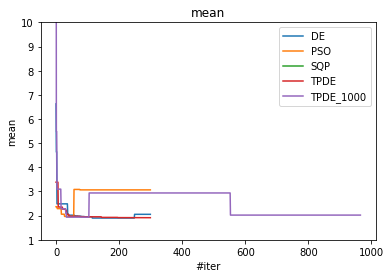

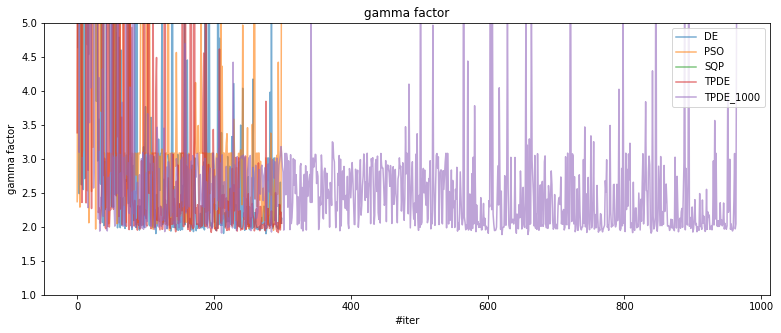

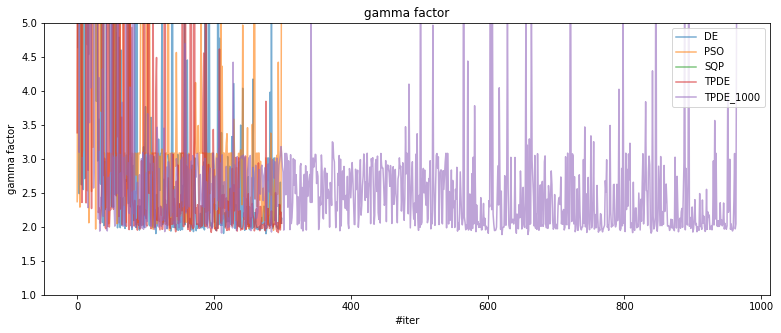

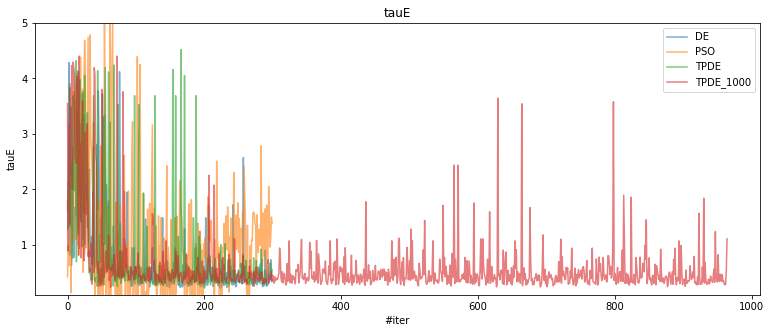

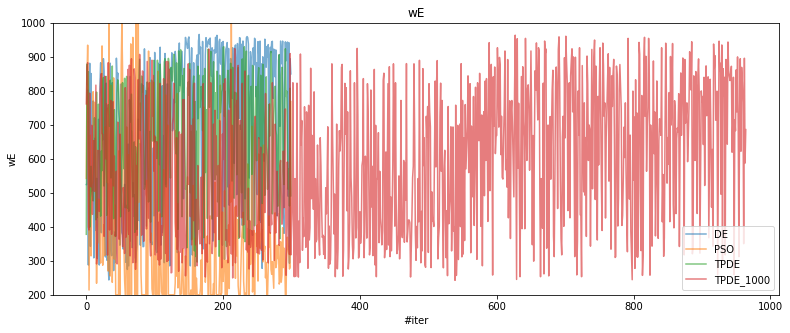

DE
tauE mean 0.7816 - std 0.8062
wE mean 692.3199 - std 238.9155

PSO
tauE mean 1.1435 - std 1.0914
wE mean 373.7743 - std 212.5776

SQP


IndexError: too many indices for array

In [17]:
plot_mean(CL1_means, names, ylim=[1,10])
plot_gamma(CL1_gammas, names, ylim=[1,5], alpha=0.6)
plot_gamma(CL1_gammas, names, alpha=0.6)
plot_tauE(CL1_params, names, alpha=0.6)
plot_wE(CL1_params, names, alpha=0.6)
print_mean_std(CL1_params, names)

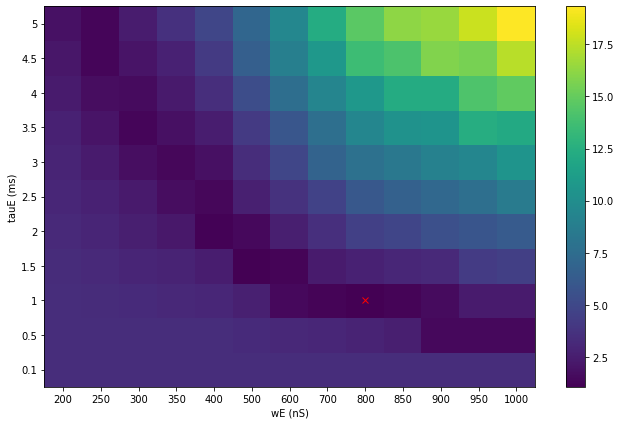